### Import stuff

In [1]:
%matplotlib inline

In [2]:
### processing 
import sys
import glob
import numpy as np
import pandas as pd
import collections 
from collections import defaultdict
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.patches as mpatches

### plotting
import seaborn as sns
import matplotlib as mpl
from matplotlib import pyplot as plt

### statistics
from scipy.stats import ttest_ind, ttest_rel, ttest_1samp, sem, zscore, kurtosis, pearsonr, spearmanr

### signal processing
from scipy.signal import filtfilt, remez, hilbert, morlet, decimate, spectrogram, cwt

## Settings

In [3]:
# # Set plotting style
# sns.set_context('talk')

In [4]:
# Set plot settings
dpi = 300  # display pixels per inch (resolution)
fz = 20    # font size

In [5]:
# Define path
DATA_PATH = '/Users/exp/Desktop/MilanData/'

### Import data and save it into a dataframe

In [6]:
def FR_BRAINYAC(subjs, sessions):
    
    ### Create empty dataframe for data
    dd_gp = defaultdict(list)

    ### Loop through subjects ###
    for subj in subjs:

        if 'J' in subj:
            exp_group = 'Young adults'
        elif 'Z' in subj:
            exp_group = 'Teenagers'
        else:
            exp_group = 'N/A'   
            
        ### Loop through sessions ###
        for sesh in sessions:
            ### Assign corresponding condition ###
            if sesh == 0:
                cond = 'FR'
                lst_len = range(12)
                if subj == 'R1510Z':
                    lst_len = range(1,12)
            elif sesh == 1:
                cond = 'FR_MP'
                lst_len = range(1,12)
                if subj == 'R1510Z':
                    lst_len = range(2,12)
                    
            ### Loop through lists (trials) ###
            for lst in lst_len:
                file_enc = DATA_PATH + 'FR1/%s/session_%s/%s.lst' % (subj, sesh, lst)
                file_rec = DATA_PATH + '/FR1/%s/session_%s/%s-resp.lst' % (subj, sesh, lst)

                ### Open encoding and recall files ###
                with open(file_enc, 'r') as f_enc, open(file_rec, 'r') as f_rec:
                    line_enc = f_enc.read().splitlines()
                    line_rec = f_rec.read().splitlines()
                    
                    intrus = [j for j in [i for i in line_rec if i not in line_enc] if j]
                    intrus_count = len(intrus)
                    
                    ### Loop through words in encoding list ###
                    for serialpos, word in enumerate(line_enc):
                        if word in line_rec:
                            recalled = 1
                            recorder = np.where(word == np.array(line_rec))[0][0]                                
                        elif word not in line_rec:
                            recalled = 0
                            recorder = -1
                        
                        #########################   
                        #### CREATE DATAFRAME ###
                        #########################
                        info_for_df = {'subject': subj,
                                       'exp_group': exp_group,
                                       'condition': cond,
                                       'session': sesh,
                                       'type': 'WORD',
                                       'trial': lst+1,
                                       'intrus_per_trial': intrus_count,
                                       'serialpos': serialpos+1,
                                       'recorder': recorder+1,
                                       'item_name': word,
                                       'recalled': recalled}

                        for key, value in info_for_df.items():
                            dd_gp[key].append(value)
                        df = pd.DataFrame(data = dd_gp)

                    #df.to_pickle('/home1/tamara.gedankien/BRAINYAC_FR_data.pkl')
    return df


In [7]:
# from glob import glob
# subjs = [f[33:39] for f in glob('/home1/tamara.gedankien/data/FR1/R*')]

subjs = ['R1556J','R1555J','R1510Z','R1559Z','R1554J','R1558J',
         'R1511Z','R1557J','R1553J', 'R1512Z', 'R1513Z']
sessions = [0,1]

df = FR_BRAINYAC(subjs, sessions)
print('Done!')

Done!


## Plotting

### Memory performace

In [8]:
# Statistically test memory performance
t,p = ttest_rel(df[df['condition']=='FR'].groupby(by=['subject']).mean()['recalled'].values,
                df[df['condition']=='FR_MP'].groupby(by=['subject']).mean()['recalled'].values)
print('t-stat: %s, p-val: %s' % (t,p))

t-stat: -2.56600846174, p-val: 0.0280822762819


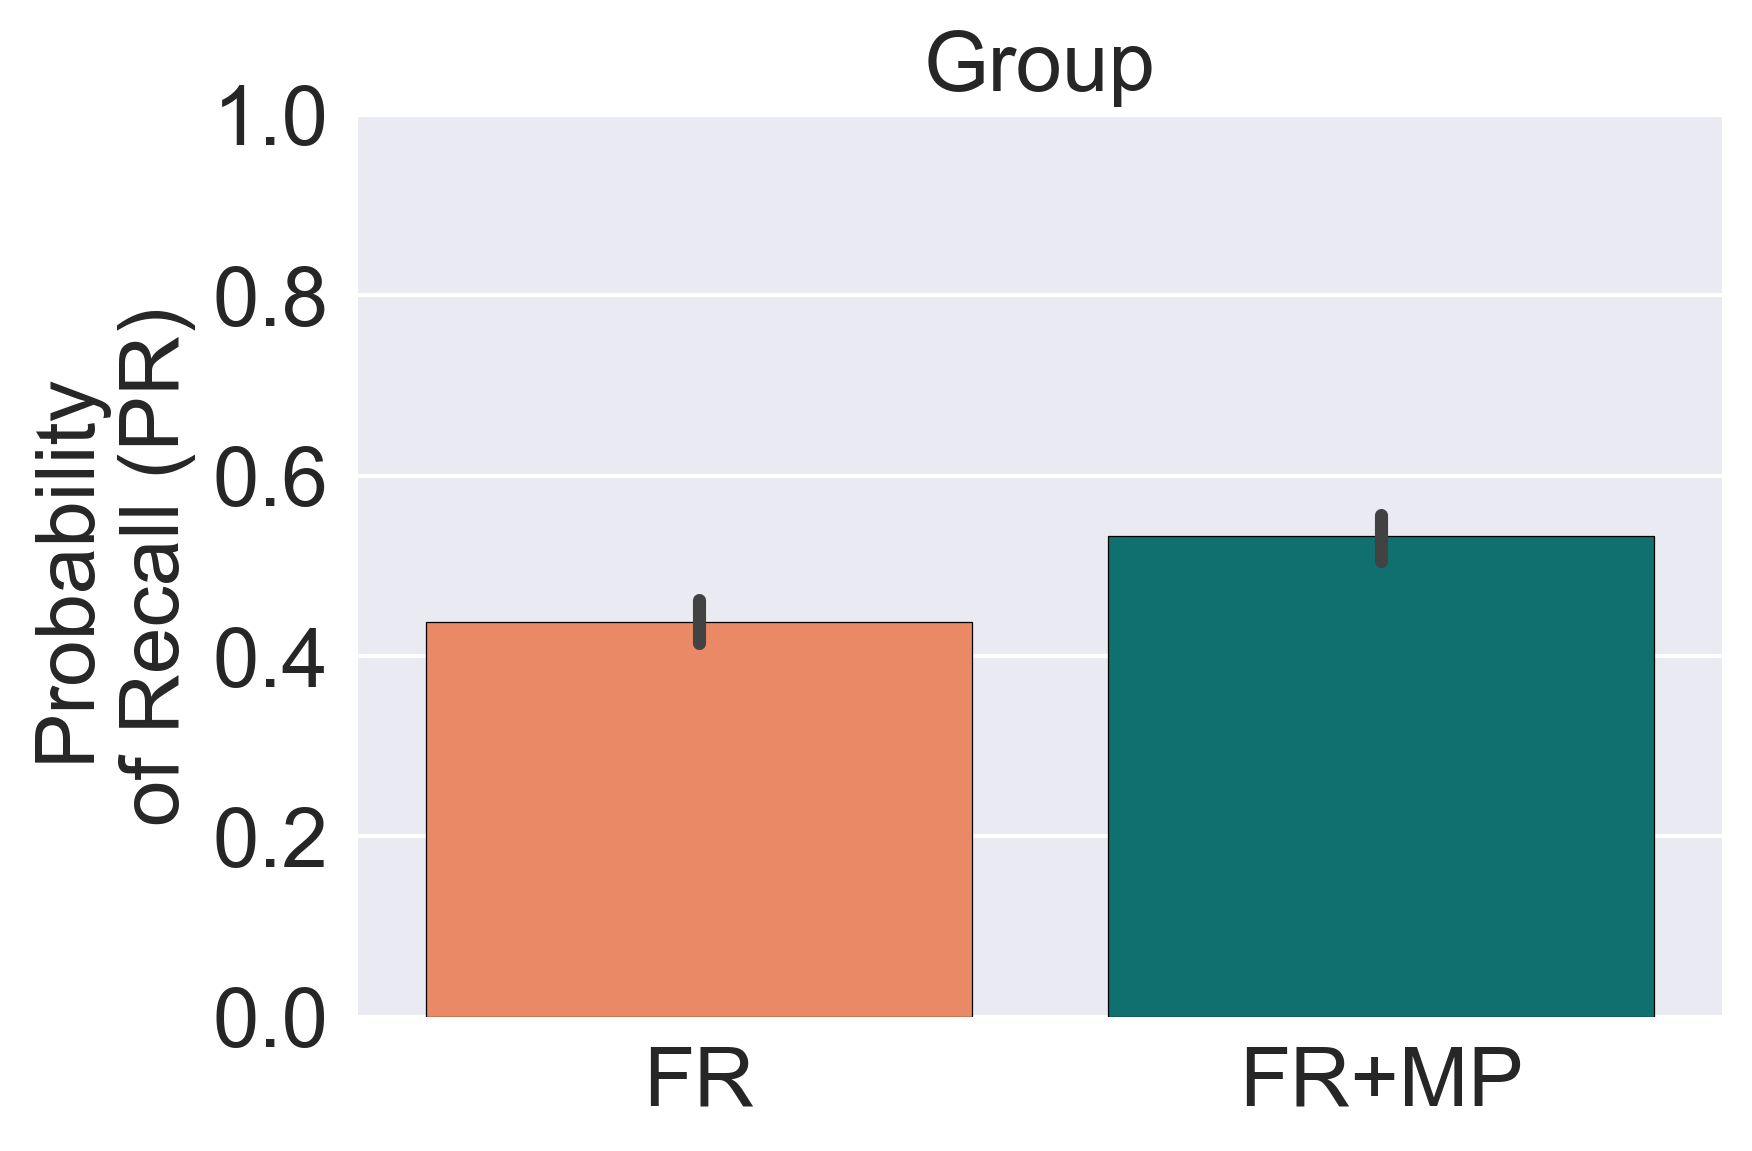

In [9]:
# Plot memory performance
with PdfPages('figures/Fig1_Prob_of_Recall.pdf') as pdf:

    ###### SUBJECT PLOTS #######
#     for count, subj in enumerate(df['subject'].unique()): 
#         fig, ax = plt.subplots(figsize=(6,4), dpi=dpi)
#         ax = sns.barplot(ax=ax, x="condition", y="recalled", data=df[df['subject']==subj], palette=['grey'], edgecolor='k', ci=None)
#         ax = sns.lineplot(ax=ax, x="condition", y='recalled', data=df[df['subject']==subj],  color='k', lw=2, ci=None)
#         ax.set_xticks([0,1])
#         ax.set_ylim([0,1])
#         ax.set_xticklabels(['Free Recall', 'Free Recall + Memory Palace'], fontsize=fz)
#         ax.set_xlabel(None)
#         ax.set_ylabel('Probability of Recall (PR)', fontsize=fz)
#         ax.set_title(subj)
#         ax.tick_params(axis='both', which='major', labelsize=fz)  
#         ax.legend([])
#         fig.tight_layout()
#         pdf.savefig(fig)
#         plt.show()
    
    ###### GROUP PLOT #######
    fig, ax = plt.subplots(figsize=(6,4), dpi=dpi)
    ax = sns.barplot(ax=ax, x="condition", y="recalled", data=df,
                     palette=['coral', 'teal'], edgecolor='k', ci=95)
    #ax = sns.lineplot(ax=ax, x="condition", y='recalled', hue='subject', data=df, lw=2, ci=None)
    ax.set_xticks([0,1])
    ax.set_ylim([0,1])
    ax.set_xticklabels(['FR', 'FR+MP'], fontsize=fz)
    ax.set_xlabel('')
    ax.set_ylabel('Probability\nof Recall (PR)', fontsize=fz)
    ax.set_title('Group', fontsize=fz)
    ax.tick_params(axis='both', which='major', labelsize=fz)  
    
    ax.set_ylim([0, 1])
    ax.legend([])
    fig.tight_layout()
    pdf.savefig(fig)
#    plt.show()

In [10]:
###### GROUP PLOT BY GROUP #######
#     t,p = ttest_rel(df[df['condition']=='FR'].groupby(by=['subject']).mean()['recalled'].values,
#                     df[df['condition']=='FR_MP'].groupby(by=['subject']).mean()['recalled'].values)
#     print('t-stat: %s, p-val: %s' % (t,p)) 

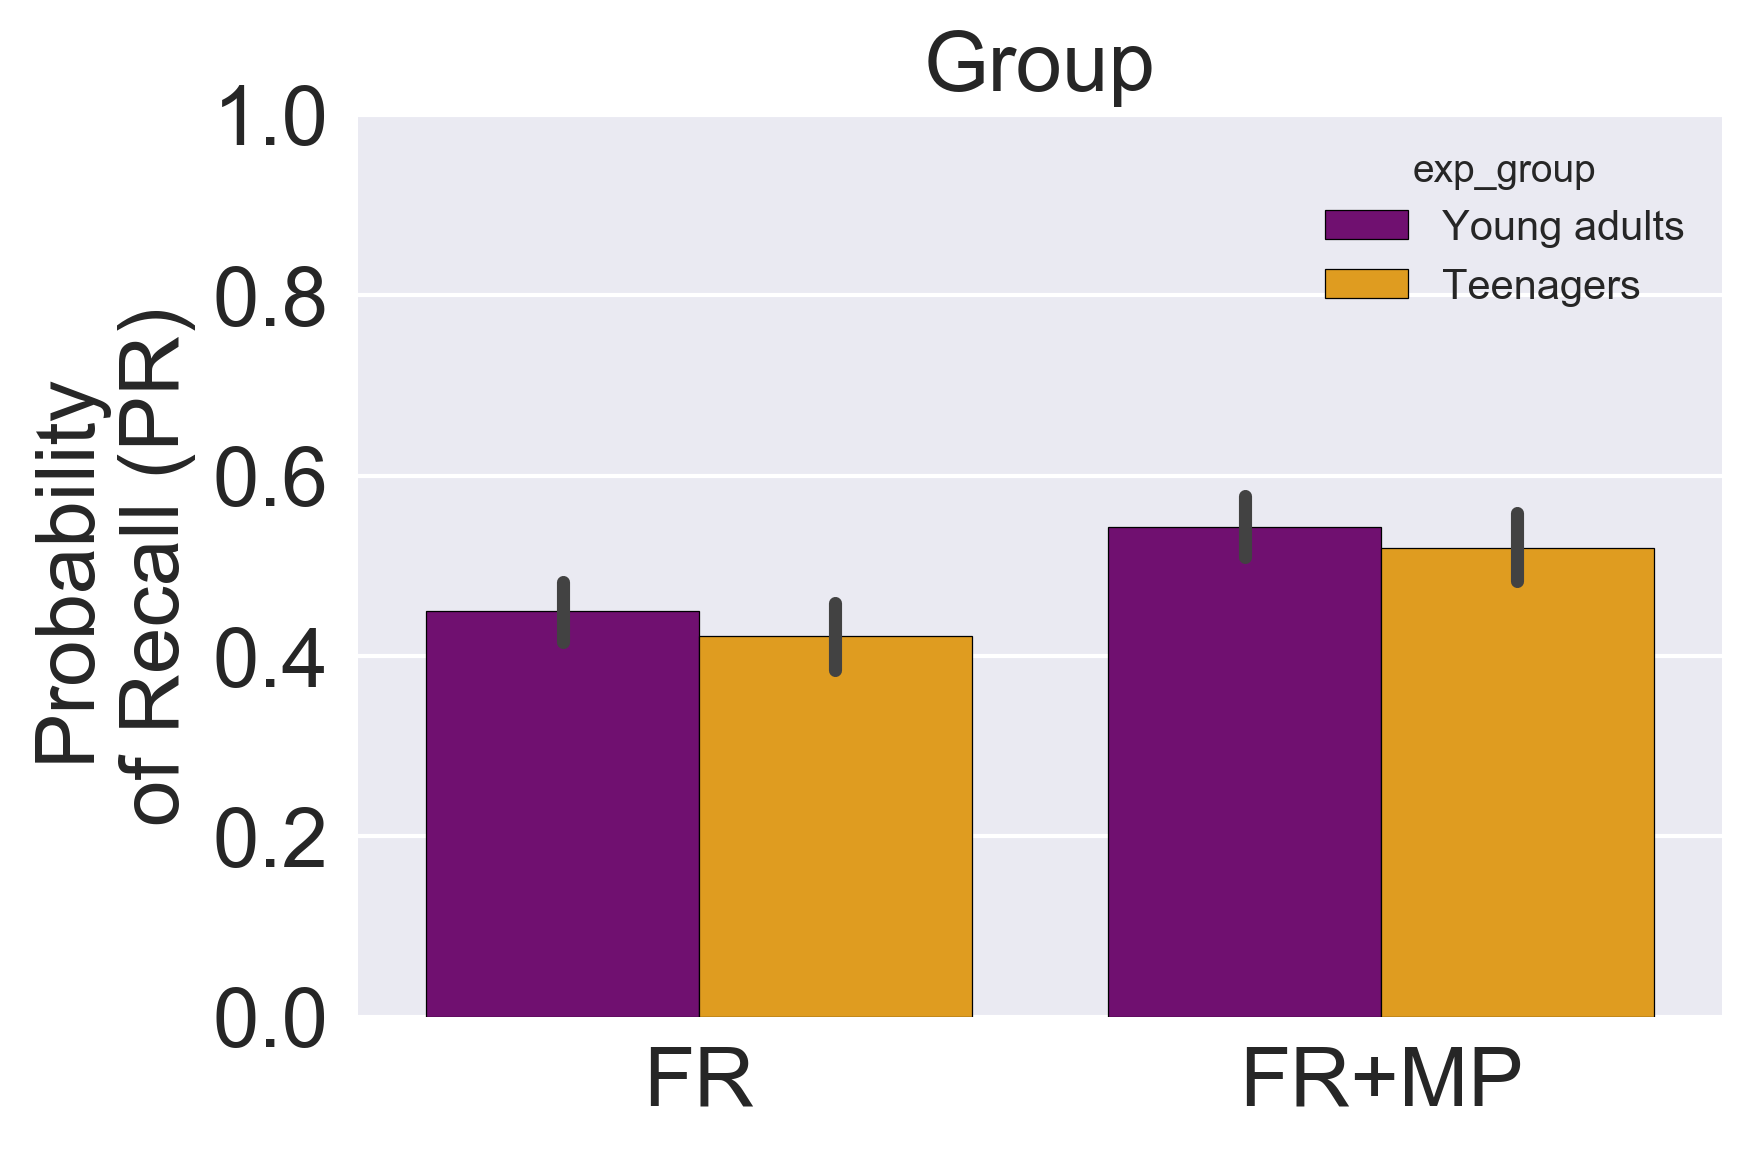

In [11]:
# Plot memory performance, split up by group
with PdfPages('figures/Fig2_Prob_of_Recall_by_Group.pdf') as pdf:
    
    fig, ax = plt.subplots(figsize=(6,4), dpi=dpi)
    ax = sns.barplot(ax=ax, x="condition", y="recalled", hue='exp_group',
                     data=df, palette=['purple', 'orange'], edgecolor='k', ci=95)    
    ax.set_xticks([0,1])
    ax.set_ylim([0, 1])
    ax.set_xticklabels(['FR', 'FR+MP'], fontsize=fz)
    ax.set_xlabel('')
    ax.set_ylabel('Probability\nof Recall (PR)', fontsize=fz)
    ax.set_title('Group', fontsize=fz)
    ax.tick_params(axis='both', which='major', labelsize=fz)
    fig.tight_layout()
    pdf.savefig(fig)
    
#     colors = ['purple', 'orange']
#     for count, exp_group in enumerate(df['exp_group'].unique()):
#         t,p = ttest_rel(df[(df['condition']=='FR') & (df['exp_group']==exp_group)].groupby(by=['subject']).mean()['recalled'].values,
#                     df[(df['condition']=='FR_MP') & (df['exp_group']==exp_group)].groupby(by=['subject']).mean()['recalled'].values)
#         print('t-stat: %s, p-val: %s' % (t,p)) 
#         fig, ax = plt.subplots(figsize=(7,5), dpi=dpi)
#         ax = sns.barplot(ax=ax, x="condition", y="recalled", data=df[df['exp_group']==exp_group], palette=[colors[count]], edgecolor='k', ci=95)
#         ax = sns.lineplot(ax=ax, x="condition", y='recalled', hue='subject', data=df[df['exp_group']==exp_group], lw=2, ci=None)
#         ax.set_xticks([0,1])
#         ax.set_xticklabels(['Free Recall', 'Free Recall + Memory Palace'], fontsize=fz)
#         ax.set_xlabel(None)
#         ax.set_ylabel('Probability of Recall (PR)', fontsize=fz)
#         ax.set_title(exp_group)
#         ax.tick_params(axis='both', which='major', labelsize=fz)  
#         ax.legend([])
#         fig.tight_layout()
#         pdf.savefig(fig)
#         plt.show()

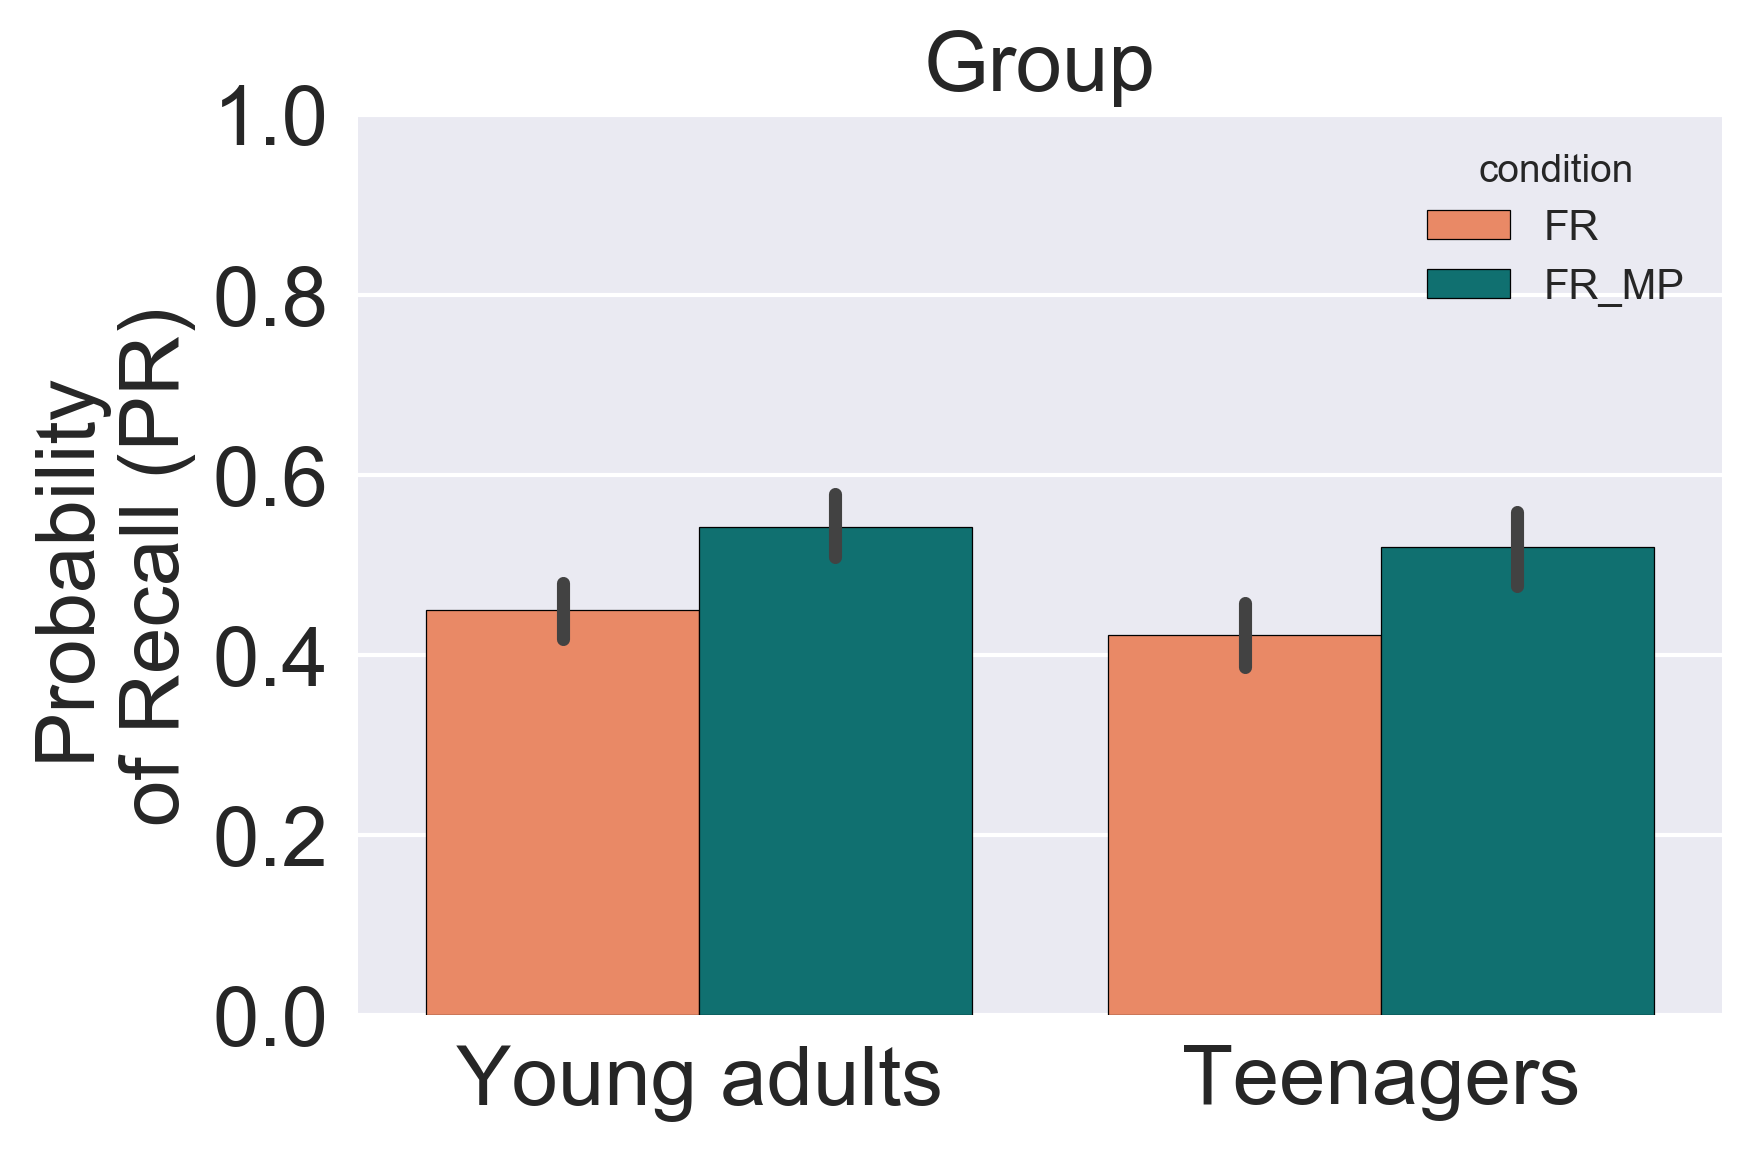

In [12]:
# Plot memory performance, split up by group
with PdfPages('figures/Fig2_Prob_of_Recall_by_Group-switched.pdf') as pdf:
    
    fig, ax = plt.subplots(figsize=(6,4), dpi=dpi)
    ax = sns.barplot(ax=ax, x="exp_group", y="recalled", hue='condition',
                     data=df, palette=['coral', 'teal'], edgecolor='k', ci=95)

    ax.set_xticks([0,1])
    ax.set_ylim([0, 1])
    #ax.set_xticklabels(['A', 'B'], fontsize=fz)
    ax.set_xlabel('')
    ax.set_ylabel('Probability\nof Recall (PR)', fontsize=fz)
    ax.set_title('Group', fontsize=fz)
    ax.tick_params(axis='both', which='major', labelsize=fz)
    fig.tight_layout()
    pdf.savefig(fig)
    
#     colors = ['purple', 'orange']
#     for count, exp_group in enumerate(df['exp_group'].unique()):
#         t,p = ttest_rel(df[(df['condition']=='FR') & (df['exp_group']==exp_group)].groupby(by=['subject']).mean()['recalled'].values,
#                     df[(df['condition']=='FR_MP') & (df['exp_group']==exp_group)].groupby(by=['subject']).mean()['recalled'].values)
#         print('t-stat: %s, p-val: %s' % (t,p)) 
#         fig, ax = plt.subplots(figsize=(7,5), dpi=dpi)
#         ax = sns.barplot(ax=ax, x="condition", y="recalled", data=df[df['exp_group']==exp_group], palette=[colors[count]], edgecolor='k', ci=95)
#         ax = sns.lineplot(ax=ax, x="condition", y='recalled', hue='subject', data=df[df['exp_group']==exp_group], lw=2, ci=None)
#         ax.set_xticks([0,1])
#         ax.set_xticklabels(['Free Recall', 'Free Recall + Memory Palace'], fontsize=fz)
#         ax.set_xlabel(None)
#         ax.set_ylabel('Probability of Recall (PR)', fontsize=fz)
#         ax.set_title(exp_group)
#         ax.tick_params(axis='both', which='major', labelsize=fz)  
#         ax.legend([])
#         fig.tight_layout()
#         pdf.savefig(fig)
#         plt.show()

### Serial position effects

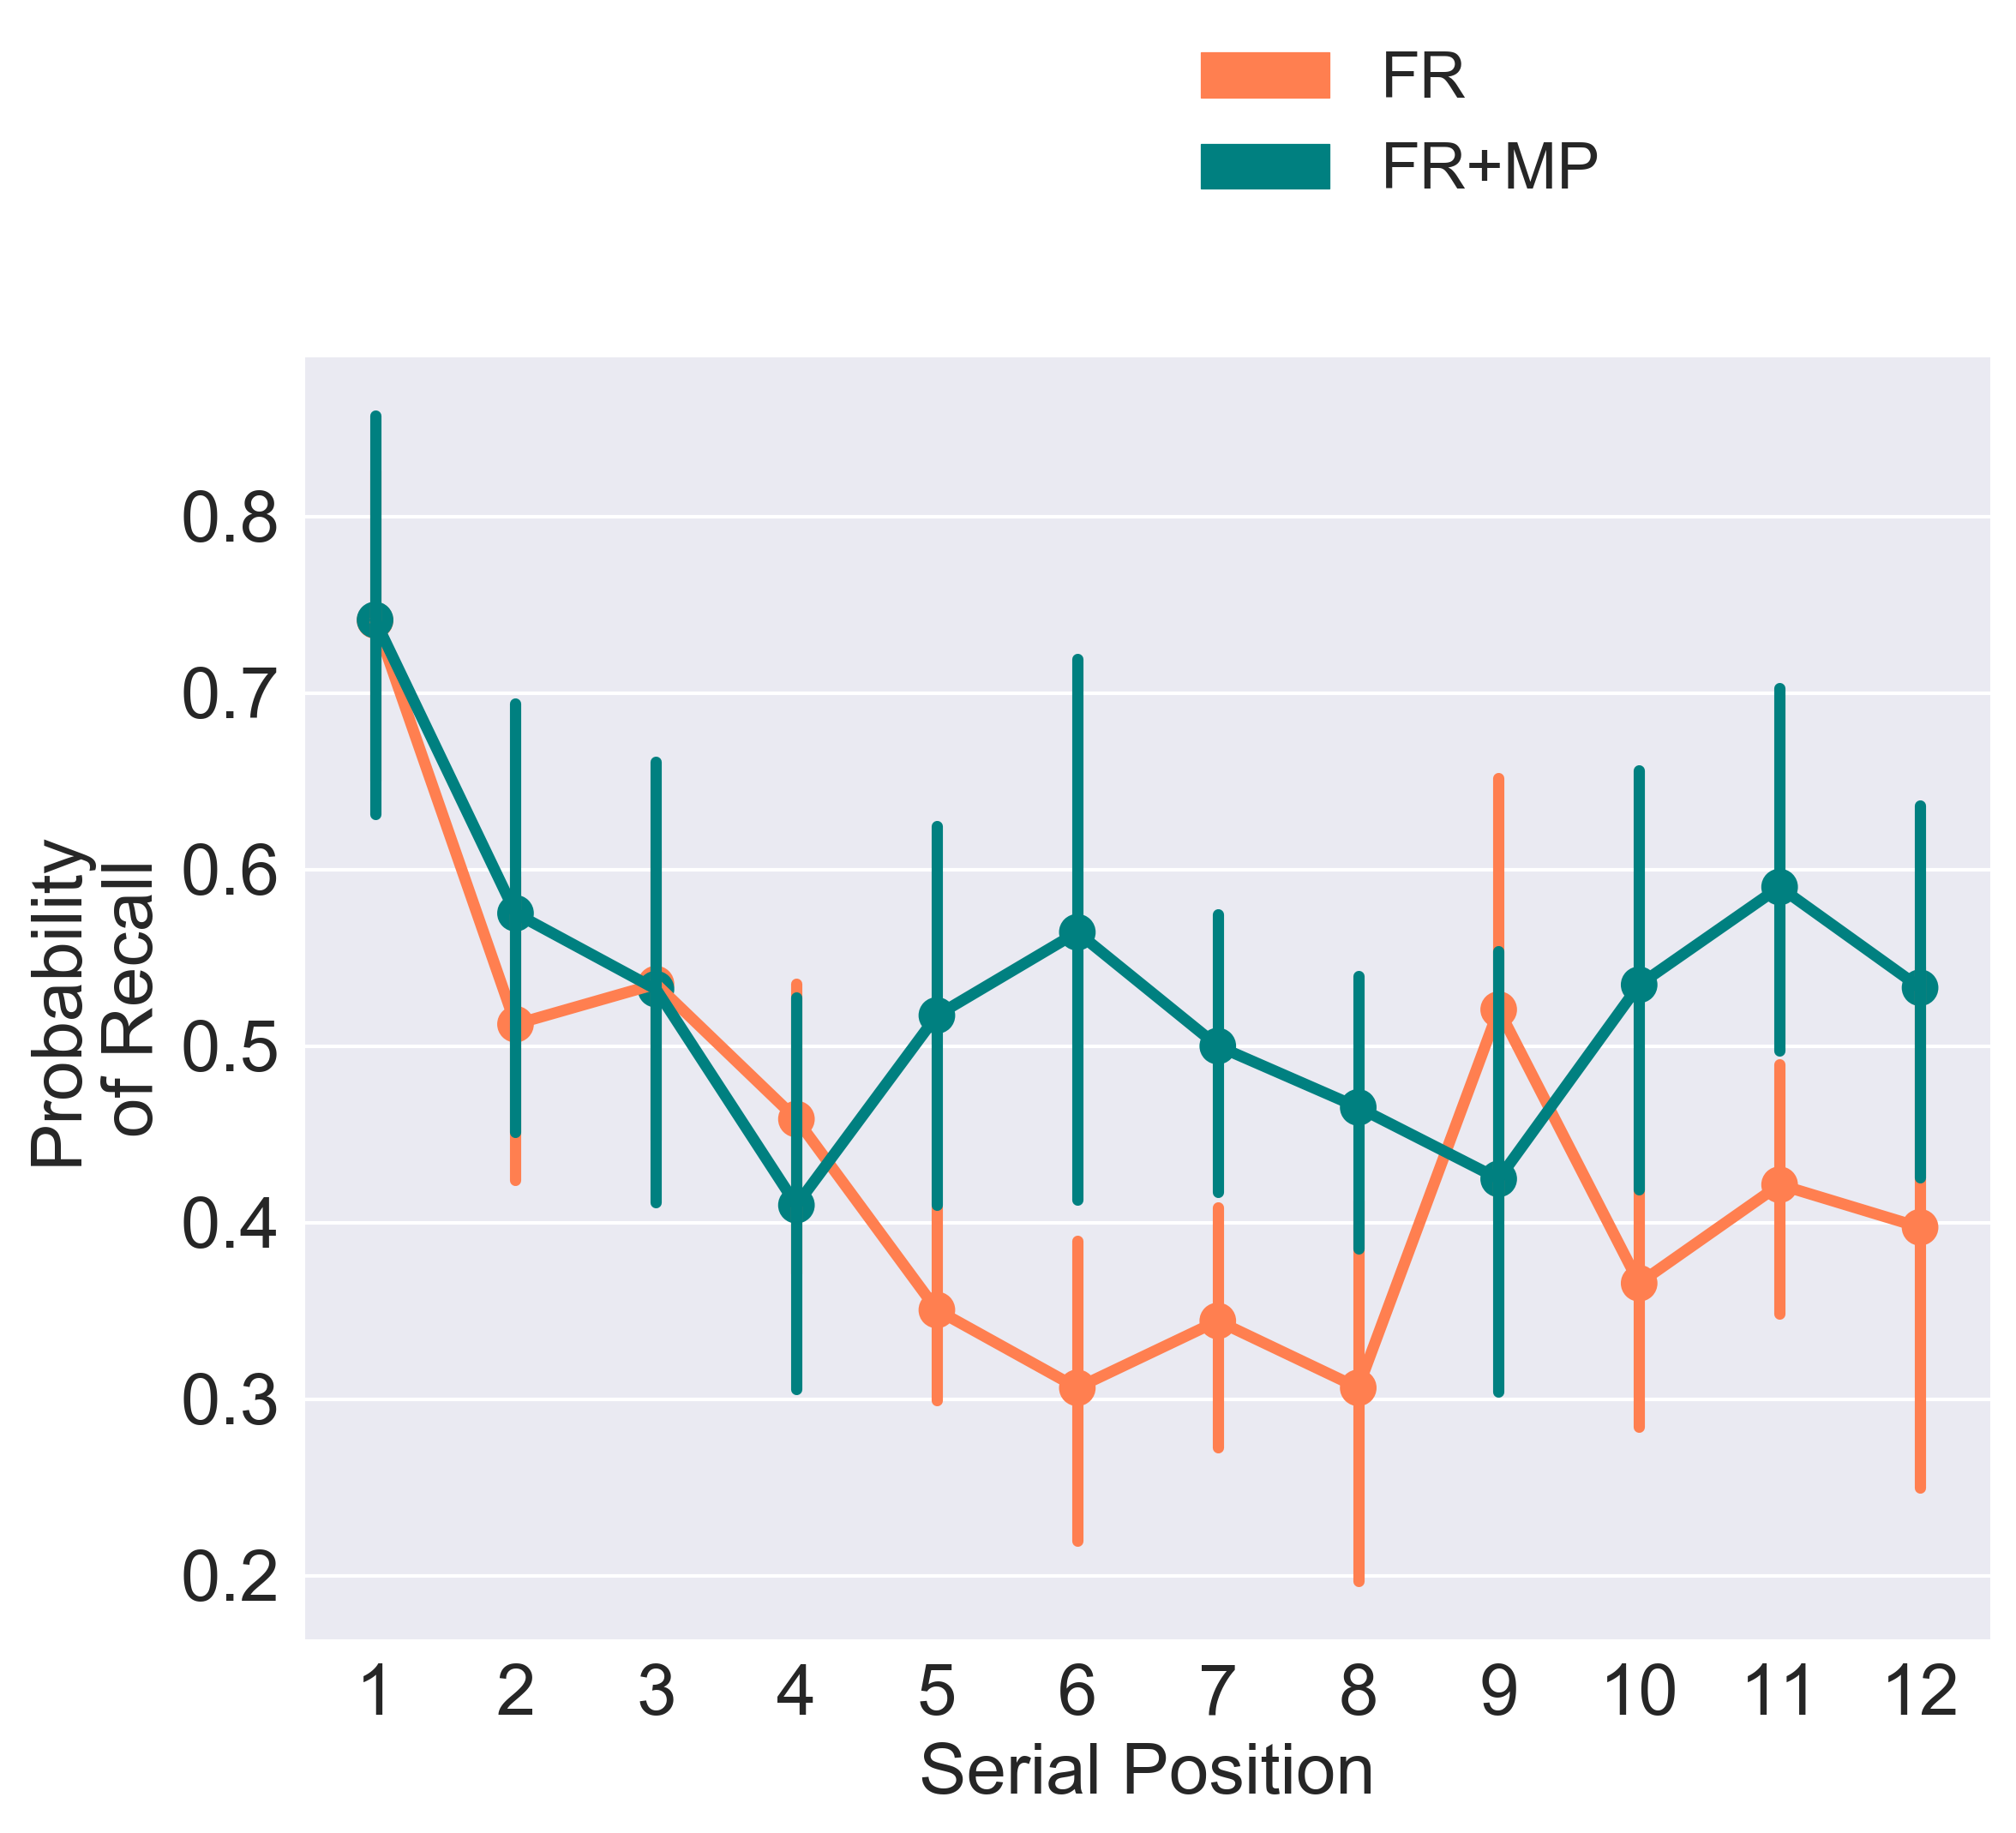

In [13]:
df1 = pd.DataFrame({'Free Recall': df[df['condition']=='FR'].groupby(by=['subject', 'serialpos']).mean()['recalled'].values,
                  'Free Recall + Memory Palace': df[df['condition']=='FR_MP'].groupby(by=['subject', 'serialpos']).mean()['recalled'].values,
                  'serialpos': np.tile(np.arange(1,13), len(df['subject'].unique()))})

with PdfPages('figures/Fig3_Prob_of_Recall_by_Serial_Pos.pdf') as pdf:
                                      
    fig, ax1 = plt.subplots(figsize=(8,6), dpi=dpi)
    grid = sns.pointplot(ax=ax1, data=df1, x='serialpos', y='Free Recall', ci=95, color='coral')
    grid = sns.pointplot(ax=ax1, data=df1, x='serialpos', y='Free Recall + Memory Palace', ci=95, color='teal')
#     ax = sns.lineplot(ax=ax1, x='serialpos', y='recalled', data=df[df['condition']=='FR'].groupby(by=['subject', 'serialpos']).mean(), color='coral', lw=2, ci=95, label='Free Recall')    
#     ax = sns.scatterplot(ax=ax1, x='serialpos', y='recalled', data=df[df['condition']=='FR_MP'].groupby(by=['subject', 'serialpos']).mean(), color='teal')
#     ax = sns.lineplot(ax=ax1, x='serialpos', y='recalled', data=df[df['condition']=='FR_MP'].groupby(by=['subject', 'serialpos']).mean(), color='teal', lw=2, ci=95, label='Free Recall + Memory Palace')
    ax1.set_xlabel('Serial Position', fontsize=fz)
    ax1.set_ylabel('Probability\nof Recall', fontsize=fz)
    ax1.set_xticks(np.arange(0,12))
    ax1.set_xticklabels(np.arange(1,13), fontsize=fz)
    ax1.tick_params(axis='both', which='major', labelsize=fz)
    plac_patch = mpatches.Patch(color='coral', label='FR')
    scp_patch = mpatches.Patch(color='teal', label='FR+MP')
    ax1.legend(handles=[plac_patch, scp_patch], fontsize=fz-2, loc='center', bbox_to_anchor=(0.65, 1.18))
    fig.tight_layout()
    pdf.savefig(fig)
    plt.show()


### Probability of recall by trial (session)

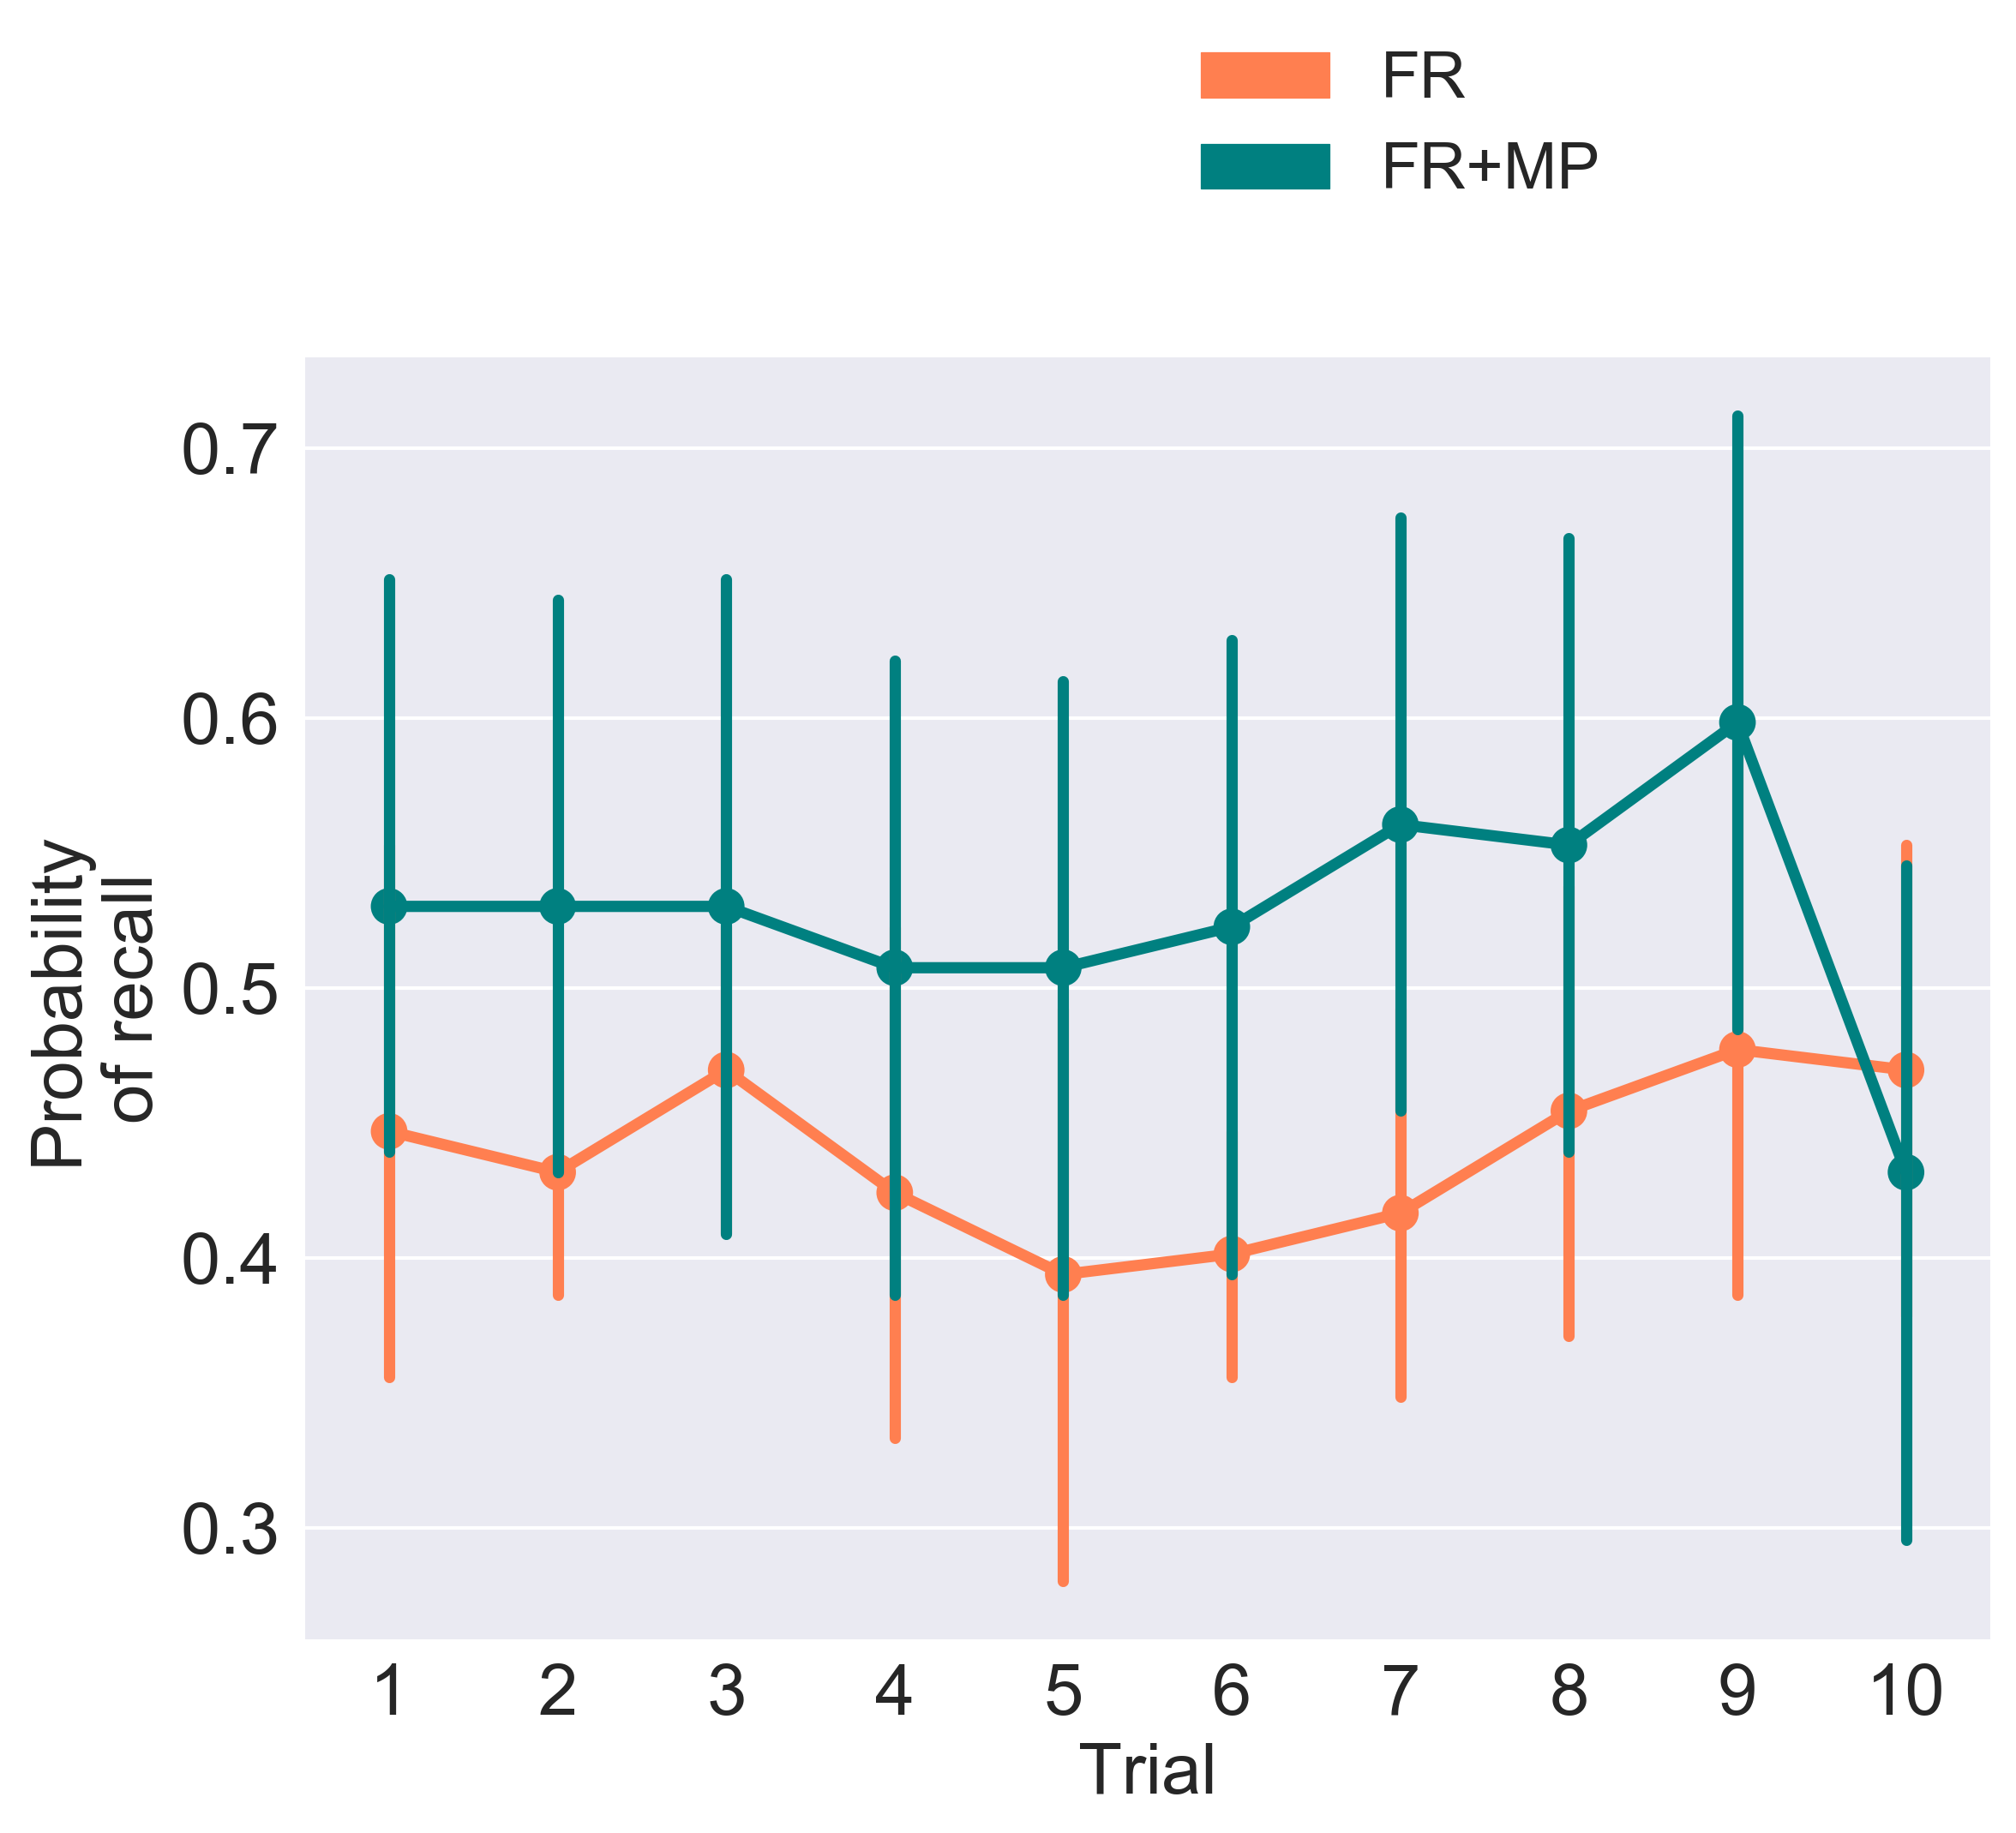

In [14]:
import matplotlib.patches as mpatches

df3 = df[df['subject']!='R1510Z']
df2 = df[df['trial']>2]

df1 = pd.DataFrame({'Free Recall': df2[df2['condition']=='FR'].groupby(by=['subject', 'trial']).mean()['recalled'].values,
                  'Free Recall + Memory Palace': df2[df2['condition']=='FR_MP'].groupby(by=['subject', 'trial']).mean()['recalled'].values,
                  'trial': np.tile(np.arange(1,11), len(df2['subject'].unique()))})

with PdfPages('figures/Fig4_Prob_of_Recall_by_Trial.pdf') as pdf:

    fig, ax1 = plt.subplots(figsize=(8,6), dpi=dpi)
    grid = sns.pointplot(ax=ax1, data=df1, x='trial', y='Free Recall', ci=95, color='coral')
    grid = sns.pointplot(ax=ax1, data=df1, x='trial', y='Free Recall + Memory Palace', ci=95, color='teal')
    ax1.set_xlabel('Trial', fontsize=fz)
    ax1.set_ylabel('Probability\nof recall', fontsize=fz)
    ax1.tick_params(axis='both', which='major', labelsize=fz)   
    plac_patch = mpatches.Patch(color='coral', label='FR')
    scp_patch = mpatches.Patch(color='teal', label='FR+MP')
    ax1.legend(handles=[plac_patch, scp_patch], fontsize=fz-2, loc='center', bbox_to_anchor=(0.65, 1.18))
    fig.tight_layout()
    pdf.savefig(fig)
    plt.show()


### Encoding-recall order match 

In [15]:
# Compute the encoding-recall order match
fr = df[(df['condition']=='FR') & (df['serialpos'] == df['recorder'])].groupby(by=['subject']).count()['recalled'].values
fr_mp = df[(df['condition']=='FR_MP') & (df['serialpos'] == df['recorder'])].groupby(by=['subject']).count()['recalled'].values

In [16]:
# Statistically test encoding order match
t_order, p_order = ttest_rel(fr, fr_mp)
print('t-stat: %s, p-val: %s' % (t_order, p_order))

t-stat: -1.18057874073, p-val: 0.265089031601


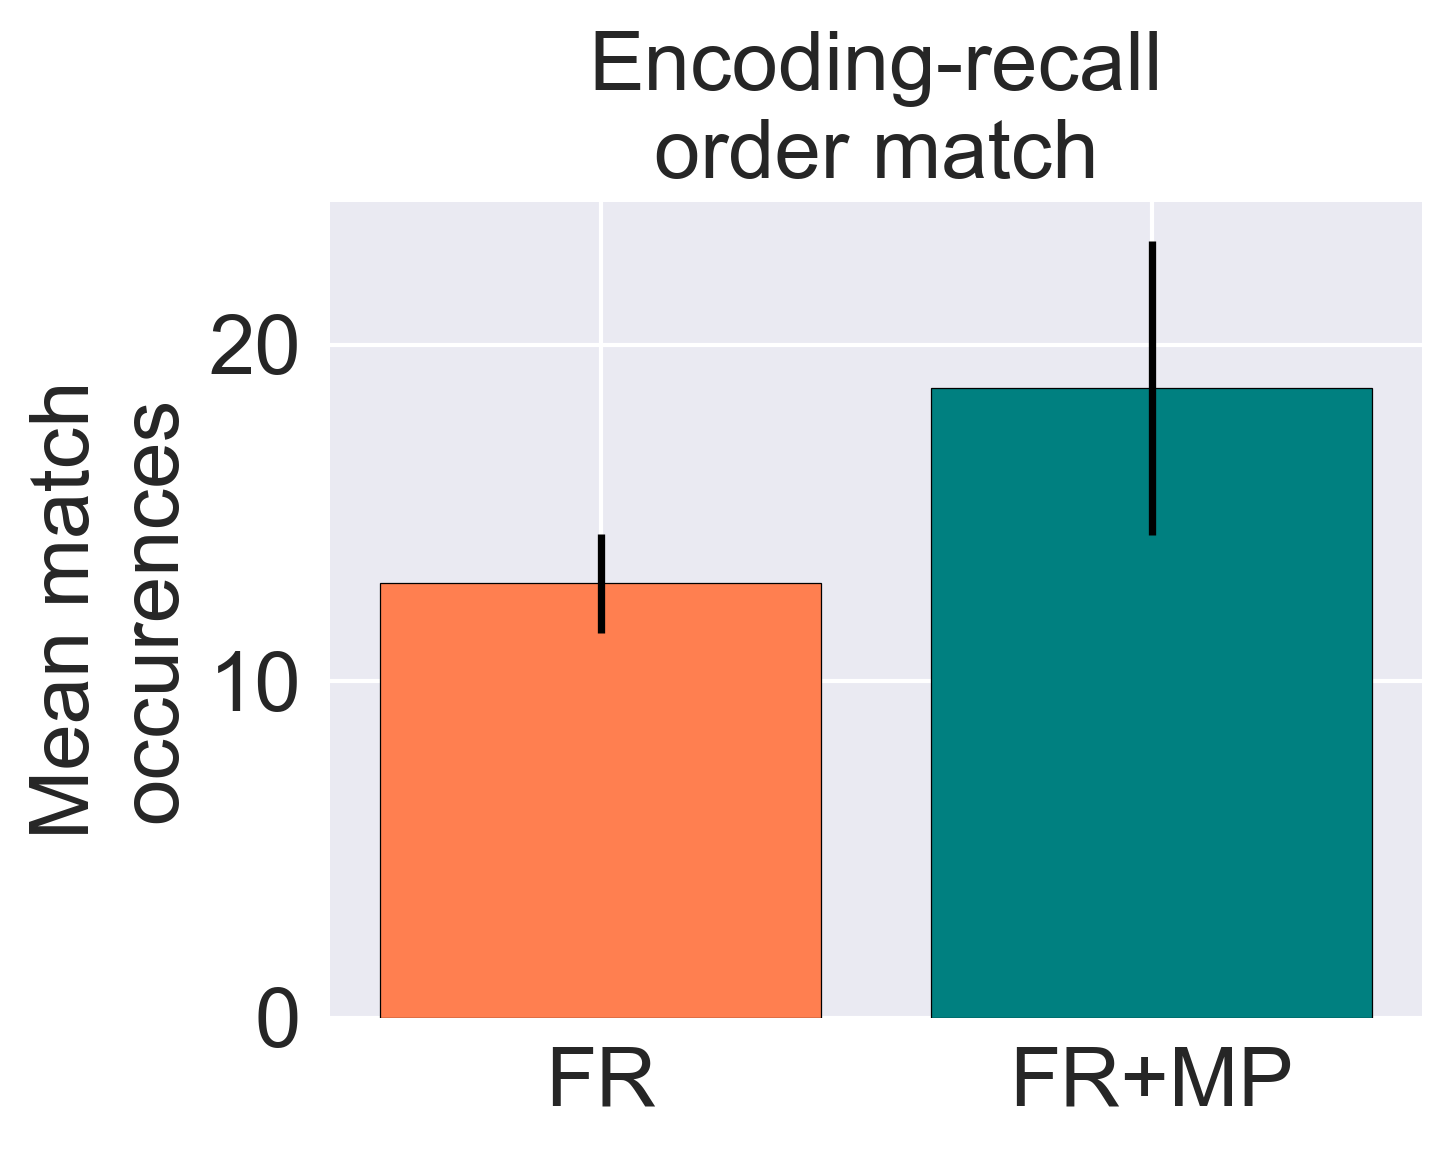

In [17]:
# Define x labels
with PdfPages('figures/Fig5_Enc-Rec_Order_Match.pdf') as pdf:

    fig, ax1 = plt.subplots(figsize=(5,4), dpi=dpi)
    ax1.bar([0, 1], [np.mean(fr), np.mean(fr_mp)],
            yerr=[sem(fr), sem(fr_mp)],
            color=['coral', 'teal'], 
            edgecolor='k')
    ax1.set_xticks([0, 1])
    ax1.set_xticklabels(['FR', 'FR+MP'])
    ax1.set_ylabel('Mean match\noccurences', fontsize=fz)
    ax1.set_title('Encoding-recall\norder match', fontsize=fz)
    ax1.tick_params(axis='both', which='major', labelsize=fz)   
    plac_patch = mpatches.Patch(color='coral', label='Free Recall')
    scp_patch = mpatches.Patch(color='teal', label='Free Recall + Memory Palace')
#     ax1.legend(handles=[plac_patch, scp_patch], fontsize=fz-2, loc='center', bbox_to_anchor=(0.65, 1.25))
    fig.tight_layout()
    pdf.savefig(fig)
    plt.show()

### Intrusions

In [18]:
# Compute sum of intrusions
fr_intrus = df[df['condition']=='FR'].groupby(by=['subject', 'trial']).mean()['intrus_per_trial'].values
fr_mp_intrus = df[df['condition']=='FR_MP'].groupby(by=['subject', 'trial']).mean()['intrus_per_trial'].values

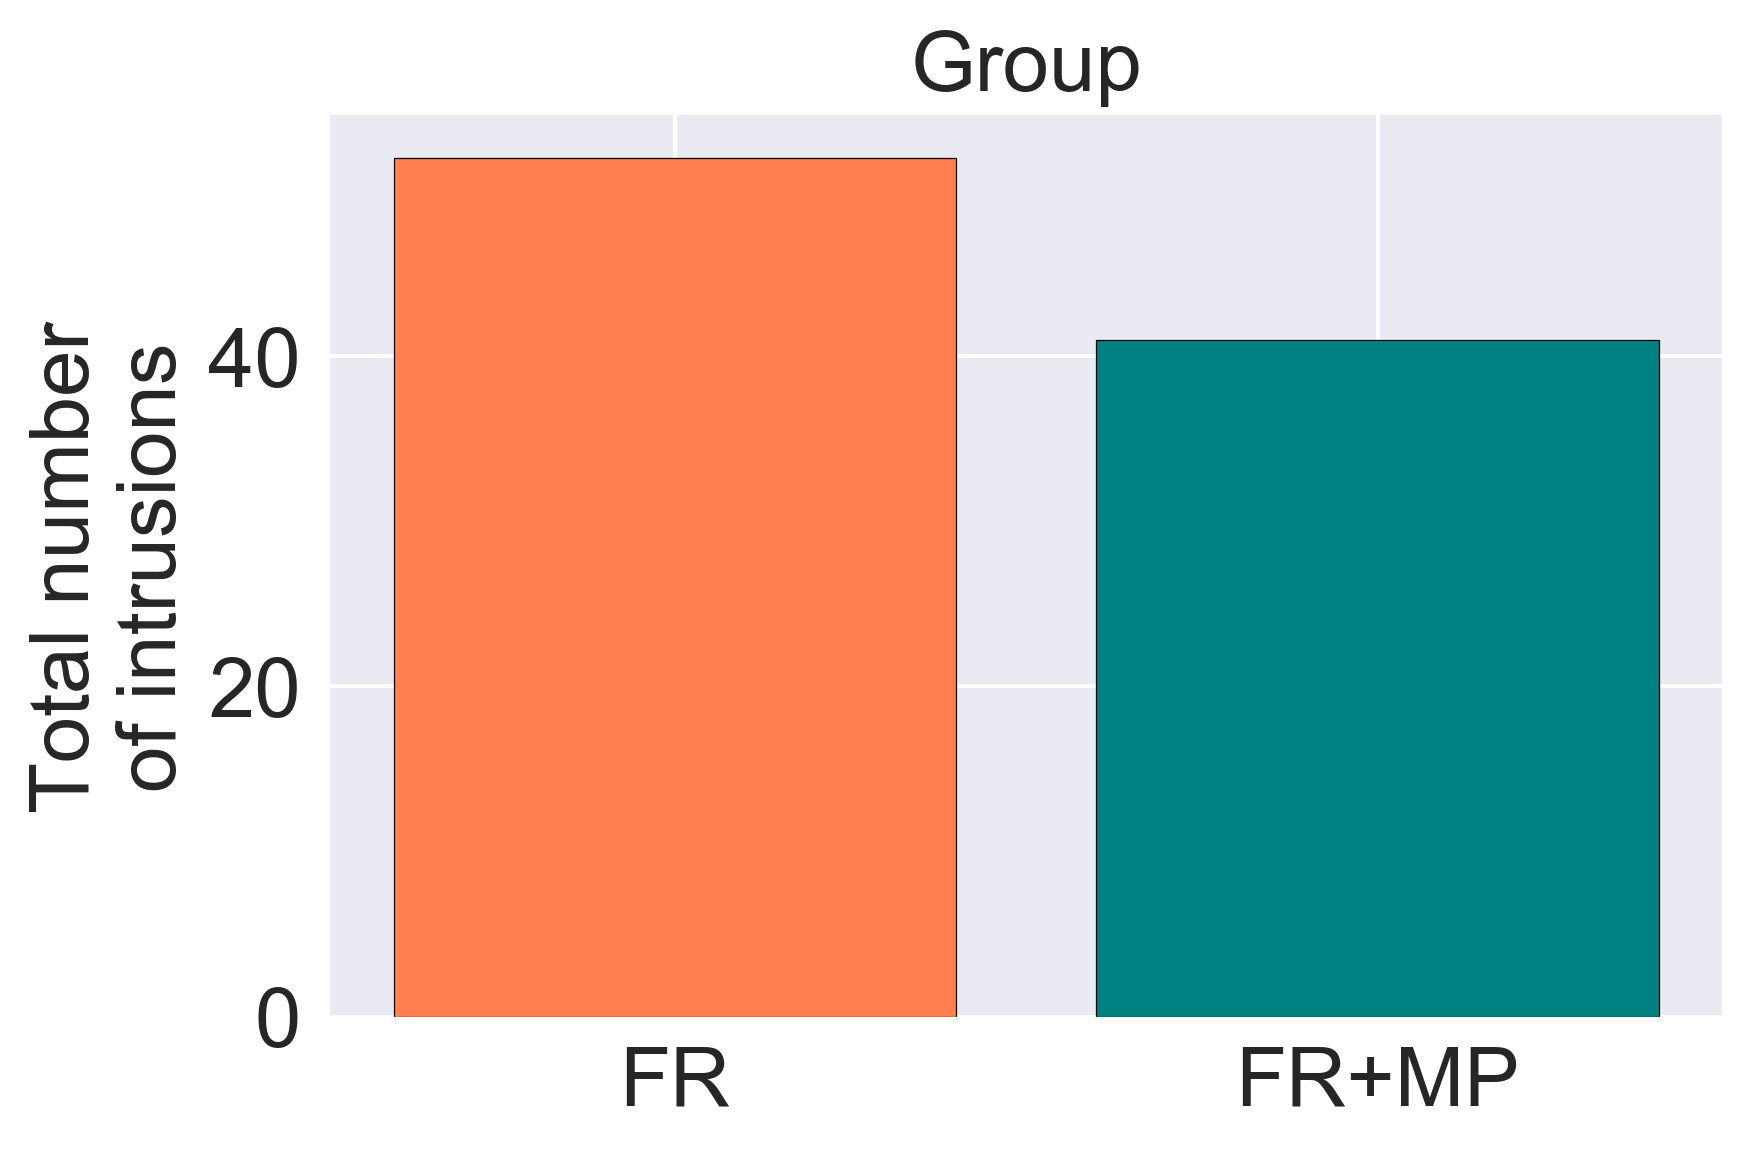

In [19]:
with PdfPages('figures/Fig6_Intrusions.pdf') as pdf:

#     for count, subj in enumerate(df['subject'].unique()): 
#         fr_intrus_subj = df[(df['condition']=='FR') & (df['subject']==subj)].groupby(by=['trial']).mean()['intrus_per_trial'].values
#         fr_mp_intrus_subj = df[(df['condition']=='FR_MP') & (df['subject']==subj)].groupby(by=['trial']).mean()['intrus_per_trial'].values,
#         X = ['FR', 'FR + MP']
#         fig, ax1 = plt.subplots(figsize=(6,4), dpi=dpi)
#         ax1.bar([0, 1],
#                 [np.sum(fr_intrus_subj), np.sum(fr_mp_intrus_subj)],
#                 color=['coral', 'teal'], edgecolor='k')
#         ax1.set_xticks([0, 1])
#         ax1.set_xticklabels(X)
#         ax1.set_ylabel('Total number\nof intrusions', fontsize=fz)
#         ax1.set_title(subj, fontsize=fz)
#         ax1.tick_params(axis='both', which='major', labelsize=fz)   
#         fig.tight_layout()
#         pdf.savefig(fig)
#         plt.show()

    ##### GROUP PLOT ####
    fig, ax1 = plt.subplots(figsize=(6,4), dpi=dpi)
    ax1.bar([0, 1], 
            [np.sum(fr_intrus), np.sum(fr_mp_intrus)],
            color=['coral', 'teal'], edgecolor='k')
    ax1.set_ylabel('Total number\nof intrusions', fontsize=fz)
    ax1.tick_params(axis='both', which='major', labelsize=fz)   
    ax1.set_xticks([0, 1])
    ax1.set_xticklabels(['FR', 'FR+MP'])
    ax1.set_title('Group', fontsize=fz)
    plac_patch = mpatches.Patch(color='coral', label='Free Recall')
    scp_patch = mpatches.Patch(color='teal', label='Free Recall + Memory Palace')
#     ax1.legend(handles=[plac_patch, scp_patch], fontsize=fz-2, loc='center', bbox_to_anchor=(0.65, 1.25))
    fig.tight_layout()
    pdf.savefig(fig)
    plt.show()

In [20]:
# Compute average intrusions
fr_intrus_avg = df[df['condition']=='FR'].groupby(by=['subject']).mean()['intrus_per_trial'].values
fr_mp_intrus_avg = df[df['condition']=='FR_MP'].groupby(by=['subject']).mean()['intrus_per_trial'].values

In [21]:
# Statistically test intrusions
t_intru, p_intru = ttest_rel(fr_intrus_avg, fr_mp_intrus_avg)
print('t-stat: %s, p-val: %s' % (t_intru, p_intru))

t-stat: 0.63569272085, p-val: 0.539251300335


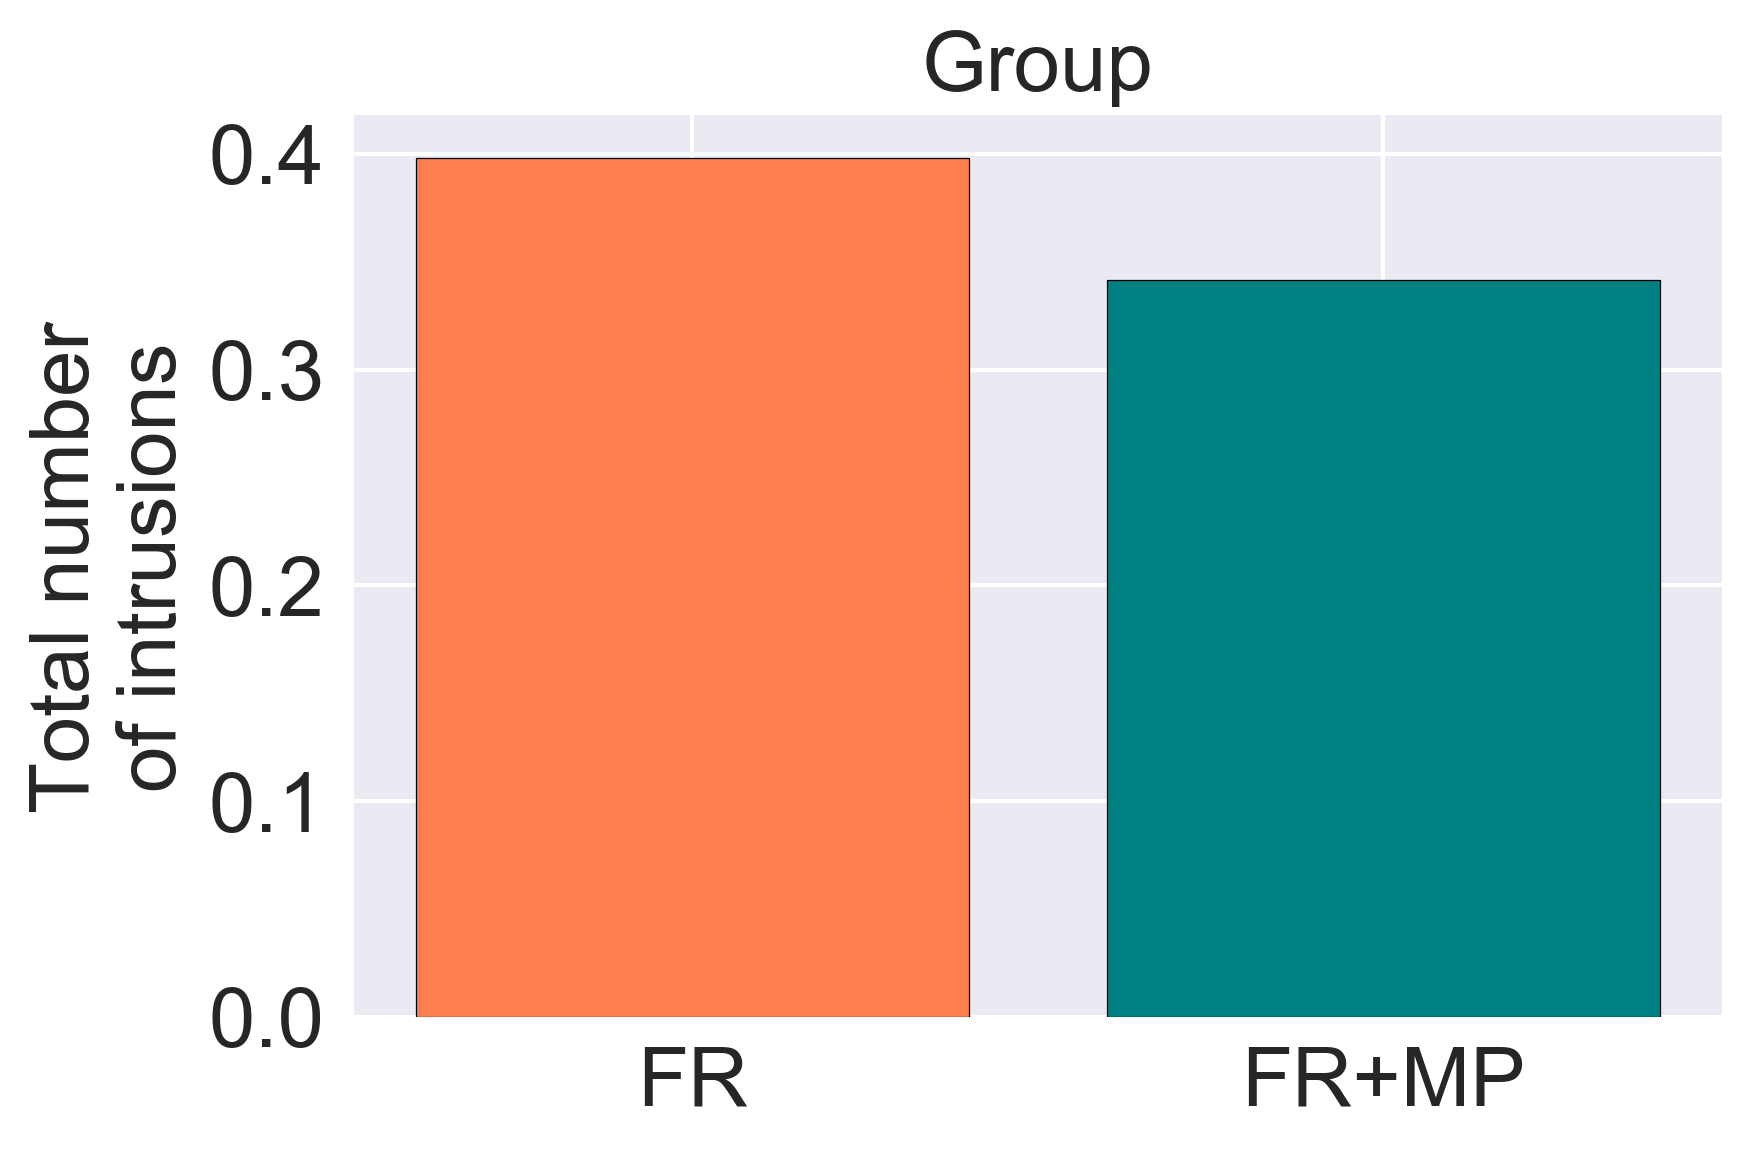

In [22]:
with PdfPages('figures/Fig7_IntrusionsAvg.pdf') as pdf:

    ##### GROUP PLOT ####
    fig, ax1 = plt.subplots(figsize=(6,4), dpi=dpi)
    ax1.bar([0, 1], 
            [np.mean(fr_intrus_avg), np.mean(fr_mp_intrus_avg)],
            color=['coral', 'teal'], edgecolor='k')
    ax1.set_ylabel('Total number\nof intrusions', fontsize=fz)
    ax1.tick_params(axis='both', which='major', labelsize=fz)   
    ax1.set_xticks([0, 1])
    ax1.set_xticklabels(['FR', 'FR+MP'])
    ax1.set_title('Group', fontsize=fz)
    plac_patch = mpatches.Patch(color='coral', label='Free Recall')
    scp_patch = mpatches.Patch(color='teal', label='Free Recall + Memory Palace')
#     ax1.legend(handles=[plac_patch, scp_patch], fontsize=fz-2, loc='center', bbox_to_anchor=(0.65, 1.25))
    fig.tight_layout()
    pdf.savefig(fig)
    plt.show()